# 6.嵌入适配器 Embedding Adaptors

## 目录
- [ 6.1 -Embedding Adaptors原理及准备工作](#61-embedding-adaptors原理及准备工作)
- [ 6.2 - Creating a dataset（创建数据集）](#62-creating-a-dataset创建数据集)
- [ 6.3 - Setting up the model（设置模型）](#63-setting-up-the-model设置模型)
- [ 6.4 - 总结](#64-总结)

在这一节中，我们将学习使用Embedding Adaptors(嵌入适配器)进行查询结果的增强。

## 6.1  Embedding Adaptors原理及准备工作

![Embedding Adapter.png](./images/Embedding%20Adapter.png)

我们通过图片了解一下Embedding Adaptors（嵌入适配器）的工作原理：

在一个系统中，用户通过应用程序(App)提交一个查询（例如“Revenue Growth”），查询被发送到大型语言模型（LLM）中。在检索部分，嵌入模型根据查询生成嵌入向量，嵌入适配器可能会对这些嵌入进行进一步处理或转换。最后，系统基于嵌入向量检索相关文档（例如“Annual Income...”），LLM会使用这些信息来生成答案。

Embedding Adaptors（嵌入适配器）是一种改变查询的嵌入，直接为了产生更好的检索结果。

我们在检索系统中插入一个额外的阶段，称为嵌入适配器。这发生在嵌入模型之后，但在我们得到最相关的结果之前。

首先，加载我们需要的辅助函数，为了有效地训练模型，这次我们需要使用`torch`，

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm

import torch

D:\Anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\Anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\Anaconda3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 

生成我们的嵌入函数并将所有内容加载到`chroma_collection`集合中

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

投射我们的嵌入数据

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [03:21<00:00,  1.73it/s]


与以前相同，配置`OPENAI_API_KEY`

In [4]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

## 6.2 Creating a dataset（创建数据集）

与以前相同（增加不同的系统指示）

In [5]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 系统角色消息，它指示模型扮演一个有帮助的、专业的财务研究助手角色。
            # 提供的内容是一个明确的任务描述，要求模型提出10到15个短问题，
            # 这些问题在分析年度报告时非常重要。
            # 这个指示还特别要求模型不要输出复合问题，即包含多个句子或连接词的问题。
            # 同时要求每个问题单独一行，行与行之间用换行符分隔。
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

使用LLM进行生成我们的15个问题

In [6]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What is the company's net income for the current fiscal year?
2. How much revenue did the company generate during the year?
3. What is the company's operating profit margin?
4. Has the company increased its total assets compared to the previous year?
5. What is the company's debt-to-equity ratio?
6. What was the company's average inventory turnover during the year?
7. How much cash did the company generate from operating activities?
8. Did the company repurchase any of its own shares during the year?
9. What dividends did the company declare and pay to its shareholders?
10. What were the company's research and development expenses during the year?
11. How much goodwill does the company have on its balance sheet?
12. Did the company incur any significant restructuring and impairment charges?
13. What are the company's significant accounting policies and estimates?
14. What is the company's current ratio?
15. Has the company experienced any litigation or legal proceedings during the y

本财年公司的净收入是多少?

公司在这一年中产生了多少收入？

公司的营业利润率是多少？

与上一年相比，公司的总资产是否有所增加？

公司的负债权益比率是多少？

公司今年的平均库存周转率是多少？

公司通过经营活动产生了多少现金？

公司在本年度是否回购了自己的股份？

公司向股东宣布并支付了多少股利？

公司在这一年中的研发支出是多少？

公司资产负债表上的商誉有多少？

公司是否产生了重大的重组和减值费用？

公司的主要会计政策和估计是什么？

公司的流动比率是多少？

公司在本年度是否经历了任何诉讼或法律程序？

指定返回每个查询的前10个结果，并且要求结果包括相关文档和嵌入向量。

In [7]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

执行这段代码后，`retrieved_documents`中将包含每个查询问题检索到的文档列表。

提示模型系统（给定的陈述是否与给定的相关查询）

In [8]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        # 指示模型扮演一个有用的财务研究助手角色，
        # 并要求模型评估给定查询与声明的相关性，只输出"yes"或"no"。
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]
    # 使用OpenAI的chat API发送请求，传递模型名称、消息列表和最大令牌数。
    # 最大令牌数设置为1，因为期望的输出只有"yes"或"no"。
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    # 从响应中提取内容，即模型的输出。
    content = response.choices[0].message.content
    # 如果内容为"yes"，返回1，表示声明与查询相关；
    # 否则返回-1，表示声明与查询不相关。
    if content == "yes":
        return 1
    return -1

从检索结果中提取嵌入向量，然后为生成的查询计算嵌入向量

In [9]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

`adapter_query_embeddings`、`adapter_doc_embeddings`和`adapter_labels`三个空列表将被用于存储适配器查询的嵌入向量、文档的嵌入向量，以及对应的标签。

In [10]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

遍历生成的查询和每个查询检索到的文档，计算查询和文档的嵌入向量，并使用`evaluate_results`函数评估了每对查询和文档的相关性。对于每个查询和文档的组合，将查询的嵌入向量、文档的嵌入向量和评估结果（作为标签）分别添加到`adapter_query_embeddings`、`adapter_doc_embeddings`和`adapter_labels`列表中。

因为使用免费的openAIAPI会出现调用限制等，我们这里使用`time.sleep()`进行减缓请求速度，从而保证因请求过快而被API服务限流

这里也可以使用除openAIAPI以外的API服务。

In [11]:
import time
from tqdm import tqdm

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

        time.sleep(30)

100%|██████████| 15/15 [1:17:39<00:00, 310.63s/it]


查看新的数据集的长度

In [12]:
len(adapter_labels)

150

得到150个，这是15个查询和10个结果，并且每一个都标有相关性

使用我们的`torch`进行训练我们的嵌入适配器

将我们的数据集转换成`torch tensor`类型数据集，并全部装进`torch``

我们使用这些`Tensor`类型数据训练一个分类模型，该模型预测给定查询和文档对是否相关（即标签为1表示相关，-1表示不相关）

In [13]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

创建了一个数据集，数据集封装查询嵌入向量、文档嵌入向量和标签的张量

In [14]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## 6.3 Setting up the model（设置模型）

设置我们的嵌入适配器模型

使用适配器矩阵来更新查询嵌入向量，并计算更新后的查询嵌入向量与文档嵌入向量之间的余弦相似度。

In [15]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


使用均方误差损失来评估模型输出与真实标签之间差异

In [16]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

始化了一个适配器矩阵，这个矩阵将用于更新查询嵌入向量或者在模型中执行其他转换任务

In [17]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

建立训练循环，通过最小化损失函数来优化适配器矩阵

In [18]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]D:\Anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


打印最佳损失值

In [19]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5489634275436401


最佳损失值约为0.54，意味我们有了一半的进步。

接下来，我们看看适配器矩阵是如何影响我们的查询向量的。

使用`NumPy`的矩阵乘法函数计算`best_matrix`（一个`NumPy`数组）和`test_vector`（一个`PyTorch`张量）之间的矩阵乘法将结果转换为`NumPy`数组。

In [20]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

将上一步保存在`scaled_vector`数组进行绘制条形图

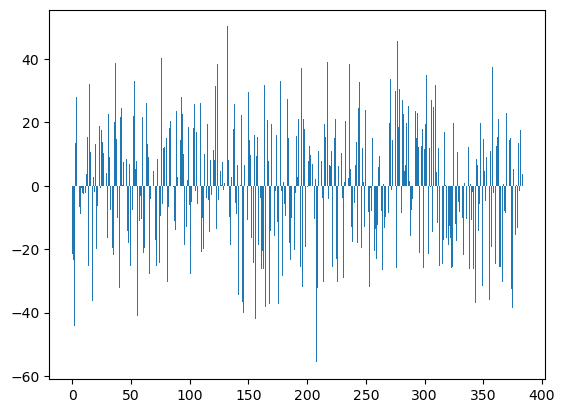

In [21]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


在这里你可以看到我们的每个维度仅由1组成的测试向量被拉伸和挤压，有些已经拉长了很多，而另一些则几乎为零。

所以这意味着我们的嵌入适配器基本上已经确定与这些维度相关性

使用`embedding_function`函数为生成的查询计算嵌入向量。

使用之前获得的最佳适配器矩阵（`best_matrix`）来调整查询嵌入向量，产生`adapted_query_embeddings`。

使用`umap`通过`project_embeddings`函数将原始查询嵌入向量和调整后的查询嵌入向量投影。

In [22]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


绘制原始查询嵌入向量、调整后的查询嵌入向量以及数据集嵌入向量的分布图。

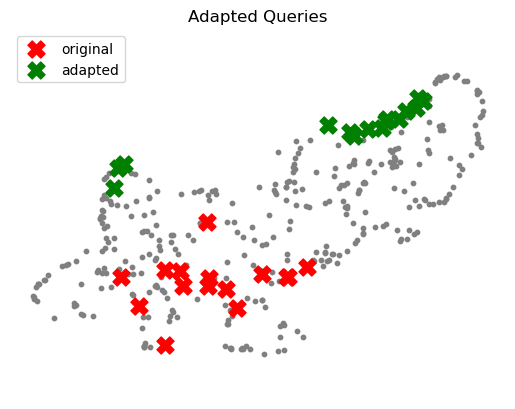

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()

红色`X`标记表示原始查询嵌入向量的分布，绿色`X`标记表示调整后的查询嵌入向量的分布

可以直接获得关于适配器矩阵调整效果的直观感受，
我们的原始查询非常分散，但是我们的调整后的查询更接近某些特定的文档嵌入向量（右上角）。

## 6.4 总结

通过本次使用Embedding Adaptors进行自定义查询嵌入向量的处理，从而达到查询结果的增强效果。